# Section 1: Simulate from various task (using the existing modules to set up).
used modules: `task`, `agent`, `dataset`

Goal: to simulate for any task and agents and store the results in the dataset. (No training/RT modelling is done)

In [3]:
from pathlib import Path
from importlib import reload
from agents import Agent
from config import configs as c
from tasks import akam_tasks as ts
from utils import *  # get_current_file_name, goto_root_dir
import pprint

reload(c)
reload(ts)
pp = pprint.PrettyPrinter(indent=4, depth = 4)
goto_root_dir.run()

### Simulate an experiment:
- [ ] PRL: pure reversal learning, Li et al. task 1
    - deteministic transition $A_i$ to $S_i$  
- [ ] RTS: reversal two-stage, Li et al. task 2
    - probabilistic transition $A_i$ to $S_i$
- [ ] NTS: transition-reversal two-stage, Li et al. task 3
    - probabilistic trnasition + outer level reversal

Currently, no import is made and only random model parameters are taken. (fitted model directories are not available)

In [2]:
tasks = {
    "PRL": ts.Two_step(com_prob=1),  # common transition always happens
    "RTS": ts.Two_step(),
    "NTS": ts.Two_step(rew_gen="trans_rev"),
}
N_blocks = 100
N_trials = 100
device = "cpu"
exp_folder = 0  #automatically generate this
seed = 0

In [3]:
reload(c)
# For now only consider RTS
agents = {}
config = {}
cog_types = ["MB0s", "LS0", "MB0", "MB1"]

for cog_type in cog_types:
    cog_config = c.sim_config_from_inputs(False, 
                                          agent_type="PRLCog", 
                                          cog_type=cog_type, 
                                          device=device, 
                                          seed=seed,
                                          num_blocks=N_blocks,
                                          num_trials=N_trials,
                                          exp_folder=0)
    config[f'PRL_{cog_type}'] = cog_config
    agents[f'PRL_{cog_type}'] = Agent(cog_config['agent_type'], config = cog_config)

In [4]:
for cog_type in cog_types: 
    agents[f'PRL_{cog_type}'].simulate(tasks["PRL"], config[f'PRL_{cog_type}'], save = True)
    
# Clearing all variables for clean environment

Simulating cog agent MB0s with params [0.5, 5.0]
n_blocks 100 n_trials 100 sim_seed 0 sim_exp_name simulated_Akam_PRL additional_name 
Simulating cog agent LS0 with params [0.1, 5.0]
n_blocks 100 n_trials 100 sim_seed 0 sim_exp_name simulated_Akam_PRL additional_name 
Simulating cog agent MB0 with params [0.5, 5.0]
n_blocks 100 n_trials 100 sim_seed 0 sim_exp_name simulated_Akam_PRL additional_name 
Simulating cog agent MB1 with params [0.5, 0.5, 5.0]
n_blocks 100 n_trials 100 sim_seed 0 sim_exp_name simulated_Akam_PRL additional_name 


In [4]:
# %reset -f
# Let's retrieve some data
# Working with PRL for now. Let's focus on PRL MB1 model
%load_ext autoreload
%autoreload 2
from path_settings import *
import joblib
from pathlib import Path
from importlib import reload
from agents import Agent
from tasks import akam_tasks as ts
from utils import *  # get_current_file_name, goto_root_dir
import pprint
import CustomMapper.CustomMapper as c
import torch

pp = pprint.PrettyPrinter(indent=4, depth = 4)
goto_root_dir.run()
LS0_data = joblib.load(SIM_SAVE_PATH / 'simulated_Akam_PRL' / 'LS0_seed0.pkl')
type(SIM_SAVE_PATH / 'simulated_Akam_PRL' / 'MB1_seed0.pkl')

pathlib.WindowsPath

In [45]:
# RUN ONLY ONCE
batch_size = 20
x_dim = 2
z_dim = 16
w_dim = 16
z_dim = 64
h_dim = 64
theta0_hidden_size = 64
theta0_hidden_activation = "relu"
theta0_output_activation = "relu"
theta_x_hidden_size = 64
theta_x_hidden_activation = "relu"
theta_x_output_activation = "linear"
sigma_x = 0.75
e_ht_hidden_size = 64
e_xu_hidden_size = 64
e_xu_hidden_activation = "relu"
e_w_hidden_size = 64
basis_num = 2 # number of basis matrices (dynamically compounded with each other)

mapper_config = {
    "task": "PRL_Bartolo", 
    "dt": 0.05, # 0.02s time step, as in Jaffe et al. 
    "T": 20, # 1s upper for RT
    "n_blocks": 100,
    "cog_data": SIM_SAVE_PATH / 'simulated_Akam_PRL' / 'LS0_seed0.pkl',
    "bias": 0.01, 
    "ndt_s": 0.1, 
    "ndt_mu": 0.01, 
    "driftscale": 5, 
    "redo_choices": False,
   
    # Trainer parameters
    "model_specs": {
        "model_name": "TaskDyVA", 
        "model_path": "Network_models.Task_DyVA",
        "model_params":{
            "batch_size": batch_size, "x_dim": 2, "z_dim": 16, "u_dim": 2, "w_dim": 16, "h_dim": 64, "basis_num": 2, # 
            # input dimension = 2 due to the simplification (can be extended to 4). 
            "theta_0_hidden_size": 64, "theta_0_hidden_activation": "relu", "theta_0_output_activation": "relu",
            "theta_x_hidden_size": 64, "theta_x_hidden_activation": "relu", "theta_x_output_activation": "linear",
            "sigma_x": 0.75, "e_ht_hidden_size": 64, "e_xu_hidden_size": 64, "e_xu_hidden_activation": "relu",
            "e_w_hidden_size": 64,
        },
    },
    "device": "cuda", 
    "scheduler": {
        "name": "ReduceLROnPlateau",
        "params": {
            "mode": "min",
            "factor": 0.1,
            "patience": 100,
            "min_lr": 5e-4,
            "cooldown": 50, 
        },
    }, 
    "optimizer_specs":{
        "optimizer_name": "Adam",
        "optimizer_params": {
            "lr": 0.001,
        },
    },
    "training_config":{
        "task_id": "Task-DyVA",
        "task_config": {
            "task": "PRL_Bartolo",
        }
    },
    
    "save_path": MODEL_SAVE_PATH ,
    "check_path": MODEL_SAVE_PATH,
    "log_path": MODEL_SAVE_PATH, # These are to be modified when the big configs gets defined
    
}
# experiment = c.CustomMapper(mapper_config)
# import pickle
# experiment.rt_model = "RELOAD"
# pickle.dump(experiment, open(DATA_PATH/"experiment_LS0.pkl", "wb"))

In [6]:
import pickle
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

In [47]:
experiment = pickle.load(open(DATA_PATH/"experiment_LS0.pkl", "rb"))
experiment.configs = mapper_config
experiment.T = 20
experiment.dt = 0.05
experiment._cog_data_frame()
experiment.reload_RT_model()
experiment.remap_data()

At this stage, I implement one task and the simplified configuration only
(100, 1980, 2)


In [48]:
torch.set_default_dtype(torch.float64)
experiment.initialise_dataloaders()
experiment.initialise_trainer(mapper_config)
experiment.trainer.train(experiment.dataloaders['train'], experiment.dataloaders['val'], 1)

torch.Size([20, 1980, 2]) torch.Size([20, 1980, 2])
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
26

ValueError: Expected parameter loc (Tensor of shape (20, 16)) of distribution MultivariateNormal(loc: torch.Size([20, 16]), covariance_matrix: torch.Size([20, 16, 16])) to satisfy the constraint IndependentConstraint(Real(), 1), but found invalid values:
tensor([[         nan,          nan,          nan,          nan,          nan,
                  nan,          nan,          nan,          nan,          nan,
                  nan,          nan,          nan,          nan,          nan,
                  nan],
        [-3.5148e+306, -9.0691e+306, -3.7727e+306, -6.1164e+305,  7.1765e+305,
          2.0142e+306,  8.9609e+304,  4.9546e+306, -2.6258e+306, -8.0903e+305,
          1.0654e+306,  7.3323e+306, -3.4302e+306, -3.8830e+306, -6.4156e+306,
          9.4718e+306],
        [-2.6025e+306, -6.7151e+306, -2.7934e+306, -4.5288e+305,  5.3137e+305,
          1.4914e+306,  6.6350e+304,  3.6685e+306, -1.9442e+306, -5.9903e+305,
          7.8886e+305,  5.4291e+306, -2.5398e+306, -2.8751e+306, -4.7503e+306,
          7.0133e+306],
        [         nan,          nan,          nan,          nan,          nan,
                  nan,          nan,          nan,          nan,          nan,
                  nan,          nan,          nan,          nan,          nan,
                  nan],
        [         nan,          nan,          nan,          nan,          nan,
                  nan,          nan,          nan,          nan,          nan,
                  nan,          nan,          nan,          nan,          nan,
                  nan],
        [-9.1723e+306, -2.3667e+307, -9.8452e+306, -1.5961e+306,  1.8728e+306,
          5.2561e+306,  2.3384e+305,  1.2929e+307, -6.8522e+306, -2.1112e+306,
          2.7803e+306,  1.9134e+307, -8.9514e+306, -1.0133e+307, -1.6742e+307,
          2.4718e+307],
        [-1.1932e+305, -3.0787e+305, -1.2807e+305, -2.0764e+304,  2.4362e+304,
          6.8375e+304,  3.0420e+303,  1.6819e+305, -8.9138e+304, -2.7465e+304,
          3.6168e+304,  2.4891e+305, -1.1645e+305, -1.3182e+305, -2.1779e+305,
          3.2154e+305],
        [         nan,          nan,          nan,          nan,          nan,
                  nan,          nan,          nan,          nan,          nan,
                  nan,          nan,          nan,          nan,          nan,
                  nan],
        [-3.6992e+306, -9.5448e+306, -3.9706e+306, -6.4372e+305,  7.5529e+305,
          2.1198e+306,  9.4310e+304,  5.2145e+306, -2.7635e+306, -8.5147e+305,
          1.1213e+306,  7.7169e+306, -3.6101e+306, -4.0867e+306, -6.7522e+306,
          9.9687e+306],
        [         nan,          nan,          nan,          nan,          nan,
                  nan,          nan,          nan,          nan,          nan,
                  nan,          nan,          nan,          nan,          nan,
                  nan],
        [-9.0035e+306, -2.3231e+307, -9.6641e+306, -1.5668e+306,  1.8383e+306,
          5.1594e+306,  2.2954e+305,  1.2692e+307, -6.7261e+306, -2.0724e+306,
          2.7291e+306,  1.8782e+307, -8.7867e+306, -9.9466e+306, -1.6434e+307,
          2.4263e+307],
        [-1.1326e+306, -2.9225e+306, -1.2157e+306, -1.9710e+305,  2.3126e+305,
          6.4905e+305,  2.8876e+304,  1.5966e+306, -8.4614e+305, -2.6071e+305,
          3.4332e+305,  2.3628e+306, -1.1054e+306, -1.2513e+306, -2.0674e+306,
          3.0523e+306],
        [         nan,          nan,          nan,          nan,          nan,
                  nan,          nan,          nan,          nan,          nan,
                  nan,          nan,          nan,          nan,          nan,
                  nan],
        [-2.5475e+303, -6.5731e+303, -2.7344e+303, -4.4330e+302,  5.2014e+302,
          1.4598e+303,  6.4947e+301,  3.5910e+303, -1.9031e+303, -5.8637e+302,
          7.7218e+302,  5.3143e+303, -2.4861e+303, -2.8143e+303, -4.6499e+303,
          6.8650e+303],
        [         nan,          nan,          nan,          nan,          nan,
                  nan,          nan,          nan,          nan,          nan,
                  nan,          nan,          nan,          nan,          nan,
                  nan],
        [         nan,          nan,          nan,          nan,          nan,
                  nan,          nan,          nan,          nan,          nan,
                  nan,          nan,          nan,          nan,          nan,
                  nan],
        [-2.4466e+306, -6.3128e+306, -2.6261e+306, -4.2575e+305,  4.9954e+305,
          1.4020e+306,  6.2375e+304,  3.4487e+306, -1.8277e+306, -5.6315e+305,
          7.4160e+305,  5.1038e+306, -2.3877e+306, -2.7029e+306, -4.4657e+306,
          6.5931e+306],
        [         nan,          nan,          nan,          nan,          nan,
                  nan,          nan,          nan,          nan,          nan,
                  nan,          nan,          nan,          nan,          nan,
                  nan],
        [-8.4931e+306, -2.1914e+307, -9.1162e+306, -1.4779e+306,  1.7341e+306,
          4.8669e+306,  2.1653e+305,  1.1972e+307, -6.3448e+306, -1.9549e+306,
          2.5744e+306,  1.7718e+307, -8.2886e+306, -9.3828e+306, -1.5502e+307,
          2.2887e+307],
        [-3.0428e+306, -7.8510e+306, -3.2660e+306, -5.2949e+305,  6.2126e+305,
          1.7436e+306,  7.7574e+304,  4.2891e+306, -2.2731e+306, -7.0037e+305,
          9.2231e+305,  6.3475e+306, -2.9695e+306, -3.3615e+306, -5.5539e+306,
          8.1997e+306]], device='cuda:0', grad_fn=<ExpandBackward0>)

In [38]:
test_tensor = torch.arange(1,4).unsqueeze(0)
torch.diag_embed(test_tensor).shape

torch.Size([1, 3, 3])

In [61]:
block = 2
experiment.cog_data[experiment.cog_data['block'] == block]

,action,stage2,reward,score,RTs,block,higher_score
200,0,0,1,"[2.5, 0.0]",0.058202,2,0
201,0,0,0,"[1.25, 0.0]",0.230930,2,0
202,0,0,0,"[0.625, 0.0]",0.332727,2,0
203,0,0,0,"[0.3125, 0.0]",1.435902,2,0
204,1,1,1,"[0.15625, 2.5]",0.016900,2,1
...,...,...,...,...,...,...,...
295,0,0,0,"[2.499980926511256, 3.343455866703507e-14]",0.074682,2,0
296,0,0,1,"[3.749990463255628, 1.6717279333517537e-14]",0.119043,2,0
297,0,0,0,"[1.874995231627814, 8.358639666758768e-15]",0.209132,2,0
298,0,0,1,"[3.437497615813907, 4.179319833379384e-15]",0.015102,2,0


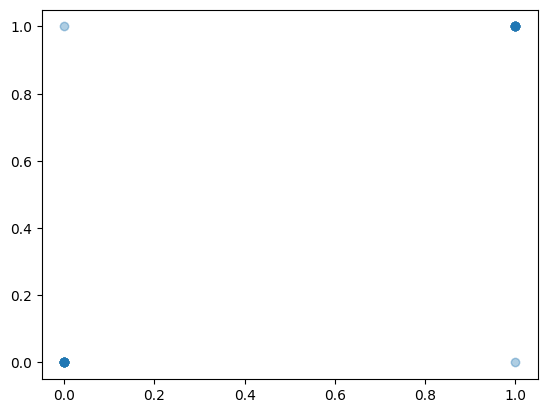

In [47]:
partial_data = experiment.cog_data[experiment.cog_data['block'] == block]
plt.scatter(partial_data['higher_score'][:-1], partial_data['action'][1:], alpha = 0.1)

# Exploration of simulated dataset

## Plot RTs

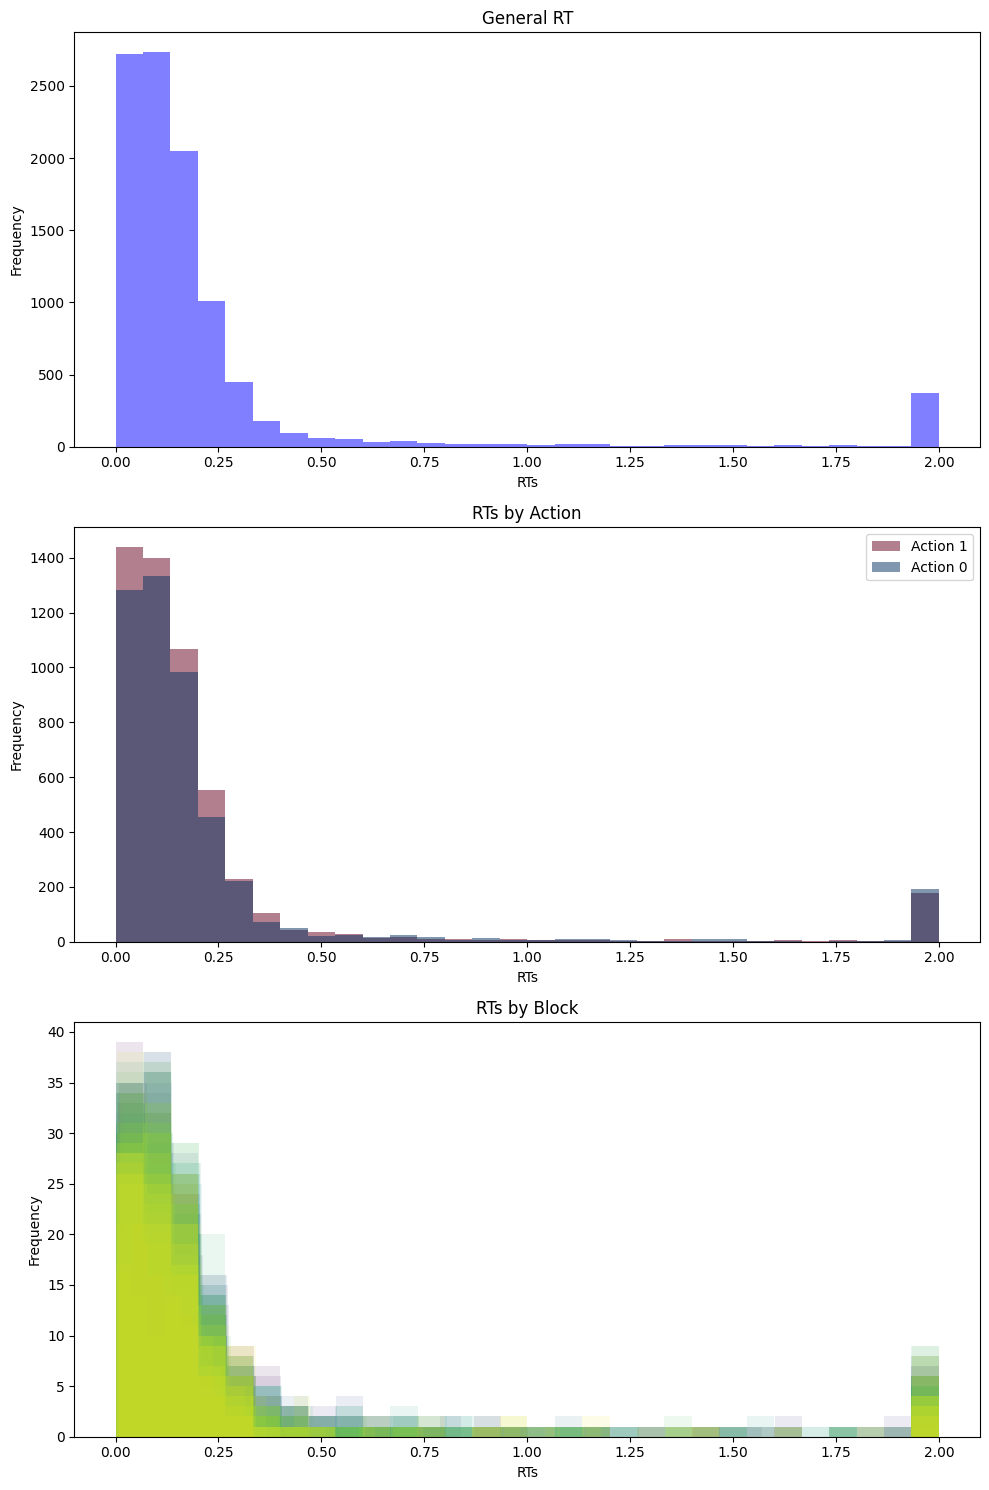

In [62]:
import matplotlib as mpl
simulated_dataset = experiment.cog_data
simulated_dataset.RTs = [min(2, x) for x in simulated_dataset.RTs] 
# Explore simulated RT profile
fig, ax = plt.subplots(3, 1, figsize=(10, 15))  # Create 3 subplots vertically aligned

# Plot 1: General RT
ax[0].hist(simulated_dataset['RTs'], bins=30, color='blue', alpha=0.5)
ax[0].set_title('General RT')
ax[0].set_xlabel('RTs')
ax[0].set_ylabel('Frequency')

color_map_action = mpl.colormaps["RdBu"]
# Plot 2: RTs for each action
for i, action in enumerate(simulated_dataset['action'].unique()):
    subset = simulated_dataset[simulated_dataset['action'] == action]
    ax[1].hist(subset['RTs'], bins=30, alpha=0.5, color=color_map_action(int(i * 256)), label=f'Action {action}')
ax[1].set_title('RTs by Action')
ax[1].set_xlabel('RTs')
ax[1].set_ylabel('Frequency')
ax[1].legend()

color_map_block = mpl.colormaps["viridis"]
# Plot 3: RTs for each block
for i, block in enumerate(simulated_dataset['block'].unique()):
    subset = simulated_dataset[simulated_dataset['block'] == block]
    ax[2].hist(subset['RTs'], bins=30, alpha=0.1, color=color_map_block(int(i * 256/(len(simulated_dataset['block'].unique
                                                                                         ())-1))),
               label=f'Block {block}')
ax[2].set_title('RTs by Block')
ax[2].set_xlabel('RTs')
ax[2].set_ylabel('Frequency')

plt.tight_layout()  # Adjust subplots to fit into the figure area
plt.show()

In [38]:
simulated_dataset.describe()

,action,stage2,reward,RTs,block
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.520100,0.520100,0.707900,0.365331,49.500000
std,0.499621,0.499621,0.454751,1.171603,28.867513
min,0.000000,0.000000,0.000000,0.000034,0.000000
25%,0.000000,0.000000,0.000000,0.061777,24.750000
50%,1.000000,1.000000,1.000000,0.121119,49.500000
75%,1.000000,1.000000,1.000000,0.199743,74.250000
max,1.000000,1.000000,1.000000,9.977037,99.000000
